<a href="https://colab.research.google.com/github/rohitpaul23/cnn_fmnist/blob/main/FMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fasion MNIST Dataset Classification

Fashion MNIST dataset, contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 × 28 pixels)

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. We can access the Fashion MNIST directly from torchvision.dataset

In [ ]:
!pip install opendatasets scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import opendatasets as od
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import random_split

## Downloading and processing Fashion MNIST Dataset

In [ ]:
from torchvision.datasets import FashionMNIST

In [ ]:
fashionDataset = FashionMNIST(root='data/', download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(fashionDataset)

60000

In [ ]:
test_dataset = FashionMNIST(root='data/', train=False)
len(test_dataset)

10000

In [ ]:
fashionDataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F172854F2D0>, 9)

Label: 9


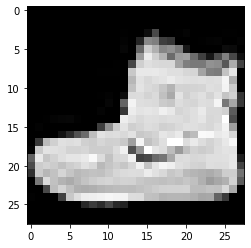

In [ ]:
image, label = fashionDataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 0


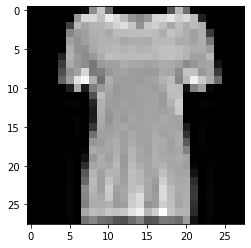

In [ ]:
image, label = fashionDataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [ ]:
import torchvision.transforms as transforms

In [ ]:
fashionTensorDataset = FashionMNIST(root='data/', 
                      train=True,
                      transform=transforms.ToTensor())

In [ ]:
fashionTensorDataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
fashion_train_ds, fashion_val_ds = random_split(fashionTensorDataset, [50000, 10000])
len(fashion_train_ds), len(fashion_val_ds)

(50000, 10000)

In [ ]:
batch_size = 128

fashion_train_loader = DataLoader(fashion_train_ds, batch_size, shuffle=True)
fashion_val_loader = DataLoader(fashion_val_ds, batch_size)

## Using Logistic Regression

In [ ]:
fashionTensorDataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
import torch.nn as nn

input_size = 28*28
output_size = 10

input_size, output_size

(784, 10)

In [ ]:
class logistic_model(nn.Module):
    def __init__(self, input_size, output_size):
      super().__init__()
      self.input_size= input_size
      self.output_size = output_size
      self.linear = nn.Linear(input_size, output_size)

    def forward(self, data):
      data = data.reshape(-1, self.input_size)
      out = self.linear(data)
      return out

In [ ]:
model = logistic_model(input_size, output_size)

In [ ]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [ ]:
model.linear.weight.shape

torch.Size([10, 784])

In [ ]:
for images, labels in fashion_train_loader:
    print(images.shape)
    out = model(images)
    break

out.shape, out[0]

torch.Size([128, 1, 28, 28])


(torch.Size([128, 10]),
 tensor([-0.3736,  0.1089,  0.3383,  0.2201,  0.5129, -0.2635,  0.3167, -0.1891,
          0.4192, -0.2517], grad_fn=<SelectBackward0>))

In [ ]:
import torch.nn.functional as F

Defining the accuracy function using softmax concept

In [ ]:
def accuracy(outs, labels):
  probs = F.softmax(outs, dim=1)
  max_prob, pred = torch.max(probs, dim=1)
  acc = torch.sum(pred == labels)/len(pred)
  return acc

In [ ]:
accuracy(out, labels)

tensor(0.1094)

Using cross entropy as a loss function as it is differentiable

In [ ]:
loss_func = F.cross_entropy

In [ ]:
loss = loss_func(out, labels)
loss

tensor(2.3441, grad_fn=<NllLossBackward0>)

**Combining all the concepts above**

In [ ]:
class final_logistic_model(nn.Module):
    def __init__(self, input_size, output_size):
      super().__init__()
      self.input_size= input_size
      self.output_size = output_size
      self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, data):
      data = data.reshape(-1, self.input_size)
      out = self.linear(data)
      return out
    
    #Used in Training in fit()
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    #Calculating the loss used in evaluate()
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    #Output the loss and accuracy obtained used in evaluate()
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        batch_accs = torch.stack(batch_accs).to(float)
        epoch_acc = torch.mean(batch_accs)      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    #To print the result of evaluate function used in fit()
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Training the Model

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] 
    
    for epoch in range(epochs):
         
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
fashion_model = final_logistic_model(input_size, output_size)

In [ ]:
result0 = evaluate(fashion_model, fashion_val_loader)
result0

{'val_acc': 0.050237341772151896, 'val_loss': 2.343700647354126}

In [ ]:
history1 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 1.7055, val_acc: 0.6207
Epoch [1], val_loss: 1.4134, val_acc: 0.6670
Epoch [2], val_loss: 1.2449, val_acc: 0.6716
Epoch [3], val_loss: 1.1362, val_acc: 0.6787
Epoch [4], val_loss: 1.0602, val_acc: 0.6862
Epoch [5], val_loss: 1.0036, val_acc: 0.6975
Epoch [6], val_loss: 0.9595, val_acc: 0.7053
Epoch [7], val_loss: 0.9239, val_acc: 0.7145
Epoch [8], val_loss: 0.8944, val_acc: 0.7213
Epoch [9], val_loss: 0.8696, val_acc: 0.7299


In [ ]:
history2 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.8480, val_acc: 0.7365
Epoch [1], val_loss: 0.8294, val_acc: 0.7413
Epoch [2], val_loss: 0.8126, val_acc: 0.7458
Epoch [3], val_loss: 0.7978, val_acc: 0.7524
Epoch [4], val_loss: 0.7844, val_acc: 0.7557
Epoch [5], val_loss: 0.7722, val_acc: 0.7597
Epoch [6], val_loss: 0.7611, val_acc: 0.7632
Epoch [7], val_loss: 0.7509, val_acc: 0.7652
Epoch [8], val_loss: 0.7414, val_acc: 0.7691
Epoch [9], val_loss: 0.7327, val_acc: 0.7714


In [ ]:
history3 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.7245, val_acc: 0.7738
Epoch [1], val_loss: 0.7170, val_acc: 0.7752
Epoch [2], val_loss: 0.7098, val_acc: 0.7777
Epoch [3], val_loss: 0.7031, val_acc: 0.7793
Epoch [4], val_loss: 0.6968, val_acc: 0.7806
Epoch [5], val_loss: 0.6909, val_acc: 0.7835
Epoch [6], val_loss: 0.6851, val_acc: 0.7852
Epoch [7], val_loss: 0.6797, val_acc: 0.7867
Epoch [8], val_loss: 0.6746, val_acc: 0.7875
Epoch [9], val_loss: 0.6697, val_acc: 0.7889


In [ ]:
history4 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6651, val_acc: 0.7902
Epoch [1], val_loss: 0.6606, val_acc: 0.7910
Epoch [2], val_loss: 0.6565, val_acc: 0.7918
Epoch [3], val_loss: 0.6524, val_acc: 0.7930
Epoch [4], val_loss: 0.6485, val_acc: 0.7949
Epoch [5], val_loss: 0.6448, val_acc: 0.7954
Epoch [6], val_loss: 0.6412, val_acc: 0.7961
Epoch [7], val_loss: 0.6378, val_acc: 0.7979
Epoch [8], val_loss: 0.6343, val_acc: 0.7984
Epoch [9], val_loss: 0.6311, val_acc: 0.8004


In [ ]:
history5 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6280, val_acc: 0.8008
Epoch [1], val_loss: 0.6250, val_acc: 0.8020
Epoch [2], val_loss: 0.6221, val_acc: 0.8012
Epoch [3], val_loss: 0.6193, val_acc: 0.8025
Epoch [4], val_loss: 0.6165, val_acc: 0.8029
Epoch [5], val_loss: 0.6139, val_acc: 0.8036
Epoch [6], val_loss: 0.6113, val_acc: 0.8045
Epoch [7], val_loss: 0.6089, val_acc: 0.8058
Epoch [8], val_loss: 0.6064, val_acc: 0.8064
Epoch [9], val_loss: 0.6041, val_acc: 0.8071


In [ ]:
history6 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6019, val_acc: 0.8074
Epoch [1], val_loss: 0.5997, val_acc: 0.8086
Epoch [2], val_loss: 0.5976, val_acc: 0.8089
Epoch [3], val_loss: 0.5954, val_acc: 0.8095
Epoch [4], val_loss: 0.5934, val_acc: 0.8110
Epoch [5], val_loss: 0.5915, val_acc: 0.8110
Epoch [6], val_loss: 0.5895, val_acc: 0.8114
Epoch [7], val_loss: 0.5877, val_acc: 0.8121
Epoch [8], val_loss: 0.5857, val_acc: 0.8129
Epoch [9], val_loss: 0.5839, val_acc: 0.8138


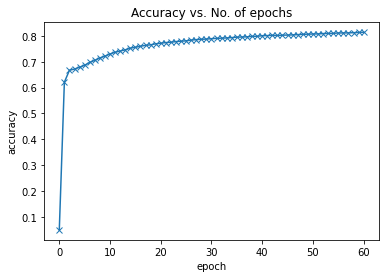

In [ ]:
history = [result0] + history1 + history2 + history3 + history4 + history5 + history6
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

After runing 60+ epoch, we are getting a validation accuracy of approx 80%

Prediction on Test Dataset

In [ ]:
fashion_test_dataset = FashionMNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Label: 9


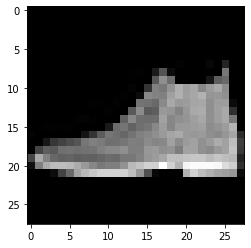

In [ ]:
image, label = fashion_test_dataset[0]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
def pred_image(data, model):
  y = model(data)
  _, pred = torch.max(y, dim = 1)
  return pred.item()

In [ ]:
pred_image(fashion_test_dataset[0][0], fashion_model)

9

Label: 1


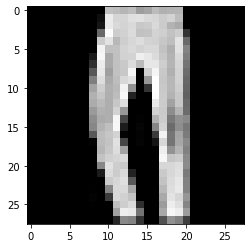

In [ ]:
image, label = fashion_test_dataset[5]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
pred_image(fashion_test_dataset[5][0], fashion_model)

1

Label: 4


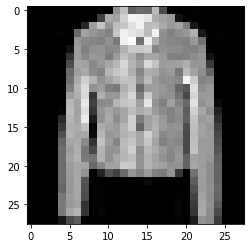

In [ ]:
image, label = fashion_test_dataset[10]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
pred_image(fashion_test_dataset[10][0], fashion_model)

4

Label: 2


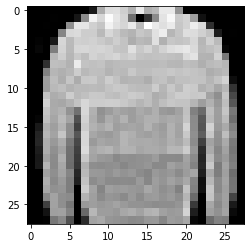

In [ ]:
image, label = fashion_test_dataset[20]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
pred_image(fashion_test_dataset[20][0], fashion_model)

0

Logistic Regression was able to give 80.23% accuracy

## Using Neural Network

Defining the model

In [ ]:
class neural_Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flattening the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function(ReLU)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
neuralModel = neural_Model(input_size, hidden_size=32, out_size = output_size)

In [ ]:
for t in neuralModel.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Enabling GPU, to speed up the computation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
fashion_train_loader = DeviceDataLoader(fashion_train_loader, device)
fashion_val_loader = DeviceDataLoader(fashion_val_loader, device)

In [ ]:
for xb, yb in fashion_val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([3, 4, 6, 9, 7, 3, 8, 4, 9, 4, 5, 5, 4, 7, 0, 3, 1, 4, 9, 1, 6, 4, 3, 8,
        8, 2, 1, 2, 1, 4, 7, 1, 2, 9, 9, 4, 7, 5, 5, 1, 9, 2, 5, 3, 3, 5, 1, 0,
        5, 7, 9, 0, 6, 7, 4, 4, 2, 7, 0, 0, 8, 0, 3, 1, 1, 6, 8, 2, 6, 8, 5, 4,
        4, 8, 8, 2, 4, 5, 8, 0, 1, 6, 1, 7, 7, 9, 4, 4, 6, 1, 4, 6, 4, 1, 8, 4,
        4, 7, 2, 5, 6, 8, 4, 0, 3, 0, 5, 8, 2, 3, 3, 1, 8, 0, 8, 4, 1, 9, 2, 1,
        1, 5, 3, 7, 3, 3, 7, 7], device='cuda:0')


Training the model

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
neuralModel = neural_Model(input_size, hidden_size=32, out_size = output_size)
to_device(neuralModel, device)

neural_Model(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(neuralModel, fashion_val_loader)]
history

[{'val_acc': 0.06457674503326416, 'val_loss': 2.3178324699401855}]

In [ ]:
history += fit(5, 0.05, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.5924, val_acc: 0.8020
Epoch [1], val_loss: 0.5068, val_acc: 0.8249
Epoch [2], val_loss: 0.4667, val_acc: 0.8396
Epoch [3], val_loss: 0.4563, val_acc: 0.8402
Epoch [4], val_loss: 0.4543, val_acc: 0.8414


In [ ]:
history += fit(5, 0.01, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.4259, val_acc: 0.8531
Epoch [1], val_loss: 0.4250, val_acc: 0.8525
Epoch [2], val_loss: 0.4220, val_acc: 0.8527
Epoch [3], val_loss: 0.4208, val_acc: 0.8523
Epoch [4], val_loss: 0.4181, val_acc: 0.8543


In [ ]:
history += fit(5, 0.005, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.4174, val_acc: 0.8548
Epoch [1], val_loss: 0.4172, val_acc: 0.8559
Epoch [2], val_loss: 0.4182, val_acc: 0.8546
Epoch [3], val_loss: 0.4151, val_acc: 0.8558
Epoch [4], val_loss: 0.4139, val_acc: 0.8573


Using only 16 epochs, able to get validation accuracy of 85.73%

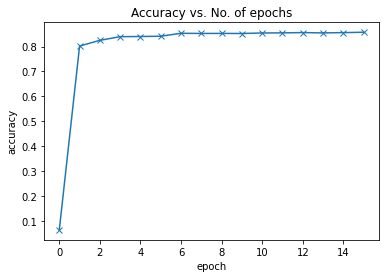

In [ ]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Predicting the class for the test image

In [ ]:
def neural_pred_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 4


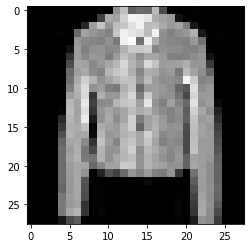

In [ ]:
image, label = fashion_test_dataset[10]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
neural_pred_image(fashion_test_dataset[10][0], neuralModel)

4

Label: 0


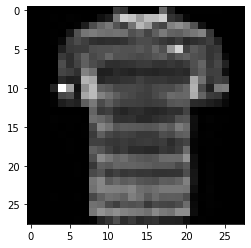

In [ ]:
image, label = fashion_test_dataset[35]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
neural_pred_image(fashion_test_dataset[35][0], neuralModel)

0

In [ ]:
test_loader = DeviceDataLoader(DataLoader(fashion_test_dataset, batch_size=128), device)
result = evaluate(neuralModel, test_loader)
result

{'val_acc': 0.8415743708610535, 'val_loss': 0.4502832889556885}

By using neural network having single hidden layer, we are able to increase the accuracy from 80% to 84.5%

## CONVOLUTIONAL NEURAL NETWORK(CNN)

Defining the model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class fashionMnistCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
                
    def forward(self, xb):
        return self.network(xb)

In [ ]:
cnnModel = fashionMnistCnnModel()
cnnModel

fashionMnistCnnModel(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (15): ReLU()
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=4096, out_features=1024, bias=True)
    (18): ReLU()
    (19): Lin

In [ ]:
to_device(cnnModel, device);

In [ ]:
for images, labels in fashion_train_loader:
    print('images.shape:', images.shape)
    out = cnnModel(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0165,  0.0365, -0.0008, -0.0083,  0.0101, -0.0176, -0.0030, -0.0348,
         0.0310, -0.0192], device='cuda:0', grad_fn=<SelectBackward0>)


Training the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(cnnModel, fashion_val_loader)

{'val_acc': 0.10314477980136871, 'val_loss': 2.3028297424316406}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, cnnModel, fashion_train_loader, fashion_val_loader, opt_func)

Epoch [0], train_loss: 0.6358, val_loss: 0.3865, val_acc: 0.8576
Epoch [1], train_loss: 0.3398, val_loss: 0.3108, val_acc: 0.8792
Epoch [2], train_loss: 0.2796, val_loss: 0.2734, val_acc: 0.8994
Epoch [3], train_loss: 0.2435, val_loss: 0.2437, val_acc: 0.9108
Epoch [4], train_loss: 0.2112, val_loss: 0.2409, val_acc: 0.9106
Epoch [5], train_loss: 0.1887, val_loss: 0.2233, val_acc: 0.9201
Epoch [6], train_loss: 0.1694, val_loss: 0.2137, val_acc: 0.9221
Epoch [7], train_loss: 0.1501, val_loss: 0.2189, val_acc: 0.9250
Epoch [8], train_loss: 0.1326, val_loss: 0.2319, val_acc: 0.9215
Epoch [9], train_loss: 0.1113, val_loss: 0.2549, val_acc: 0.9232


In [ ]:
history += fit(5, 0.0005, cnnModel, fashion_train_loader, fashion_val_loader, opt_func)

Epoch [0], train_loss: 0.0674, val_loss: 0.2587, val_acc: 0.9304
Epoch [1], train_loss: 0.0456, val_loss: 0.3263, val_acc: 0.9263
Epoch [2], train_loss: 0.0372, val_loss: 0.3505, val_acc: 0.9268
Epoch [3], train_loss: 0.0298, val_loss: 0.4419, val_acc: 0.9289
Epoch [4], train_loss: 0.0260, val_loss: 0.3640, val_acc: 0.9293


In just 15 epoch able to get a validation accuracy of 92.93%

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

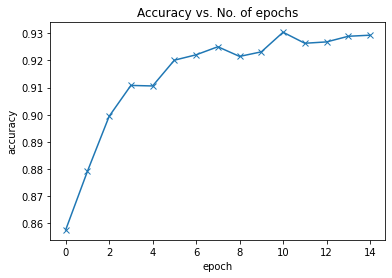

In [ ]:
plot_accuracies(history)

By using Convolutional Neural Network setting, able to get an accuracy of 92.93% increasing it from 84.5%

## Using the concept of Regularization and ResNet to improve the CNN Model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def conv_block(in_channels, out_channels, pool=False, stride = 1, padding = 1):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, stride = stride), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResCnnModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 32) 
        self.conv2 = conv_block(32, 64, pool = True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

        self.conv3 = conv_block(64, 128)
        self.conv4 = conv_block(128, 256, pool = True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, padding = 0)
        self.conv7 = conv_block(512, 512, padding = 0)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(3), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
                
    def forward(self, xb):
        out = self.conv1(xb) #32x28x28
        out = self.conv2(out) #64x14x14
        out = self.res1(out) + out #64x14x14
        out = self.conv3(out) #128x14x14
        out = self.conv4(out) #256x7x7
        out = self.res2(out) + out #256x7x7
        out = self.conv5(out) #512x7x7
        out = self.conv6(out) #512x5x5
        out = self.conv7(out) #512x3x3
        out = self.res3(out) + out #512x3x3
        out = self.classifier(out)
        return out

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
      model.train()
      train_losses = []
      lrs = []
        
      # Training Phase 
      for batch in train_loader:
        loss = model.training_step(batch)
        train_losses.append(loss)
        loss.backward()

        # Gradient clipping
        if grad_clip: 
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        optimizer.zero_grad()

        # Record & update learning rate
        lrs.append(get_lr(optimizer))
        sched.step()

      # Validation phase
      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      result['lrs'] = lrs
      
      model.epoch_end(epoch, result)
      history.append(result)
    return history

In [ ]:
finalModel = ResCnnModel(1, 10)
finalModel

ResCnnModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)


In [ ]:
finalModel = to_device(finalModel, device);

In [ ]:
history = [evaluate(finalModel, fashion_val_loader)]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr, finalModel, fashion_train_loader, fashion_val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 0.4363, val_loss: 0.3462, val_acc: 0.8749
Epoch [1], last_lr: 0.00760, train_loss: 0.3249, val_loss: 0.4174, val_acc: 0.8504
Epoch [2], last_lr: 0.01000, train_loss: 0.2903, val_loss: 0.3172, val_acc: 0.8881
Epoch [3], last_lr: 0.00950, train_loss: 0.2665, val_loss: 0.3146, val_acc: 0.8880
Epoch [4], last_lr: 0.00812, train_loss: 0.2503, val_loss: 0.3516, val_acc: 0.8703
Epoch [5], last_lr: 0.00611, train_loss: 0.2324, val_loss: 0.2402, val_acc: 0.9128
Epoch [6], last_lr: 0.00389, train_loss: 0.2057, val_loss: 0.2463, val_acc: 0.9147
Epoch [7], last_lr: 0.00188, train_loss: 0.1698, val_loss: 0.1999, val_acc: 0.9286
Epoch [8], last_lr: 0.00050, train_loss: 0.1143, val_loss: 0.1695, val_acc: 0.9425
Epoch [9], last_lr: 0.00000, train_loss: 0.0553, val_loss: 0.1742, val_acc: 0.9444


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

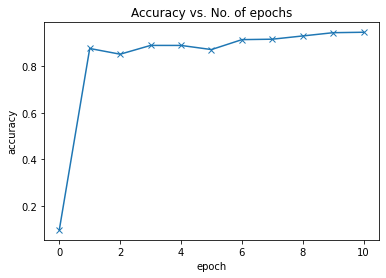

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

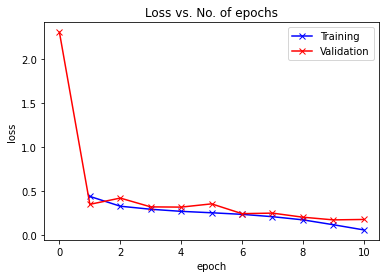

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

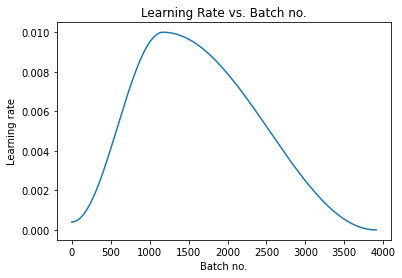

In [ ]:
plot_lrs(history)

By introducing the concept of ResNet and Regularization able to increase the accuracy from 92.9% to 94.44% in just 10 epochs
